In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (5).json


{'kaggle.json': b'{"username":"ahmedelkhamisi","key":"f9f4c8dfa48d84d6567952071d66901a"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d rupakroy/online-payments-fraud-detection-dataset

online-payments-fraud-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
from zipfile import ZipFile
file_name="online-payments-fraud-detection-dataset.zip" 
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import plotly.express as px
from numpy import mean
from numpy import std
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')

# Read Dataset

In [8]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [10]:
df.shape

(6362620, 11)

In [11]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [12]:
print(df.type.value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


In [13]:
label=LabelEncoder()
df['type']=label.fit_transform(df['type'])
df['nameOrig']=label.fit_transform(df['nameOrig'])
df['nameDest']=label.fit_transform(df['nameDest'])

In [14]:
print(df.type.value_counts())

1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: type, dtype: int64


In [15]:
#Sampling on all types with equal samples to ensure fair training
df_1=df[df["type"]==0]
df_2=df[df["type"]==1]
df_3=df[df["type"]==2]
df_4=df[df["type"]==3]
df_5=df[df["type"]==4]

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)
df_5_upsample=resample(df_5,replace=True,n_samples=20000,random_state=127)
train_df=pd.concat([df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])

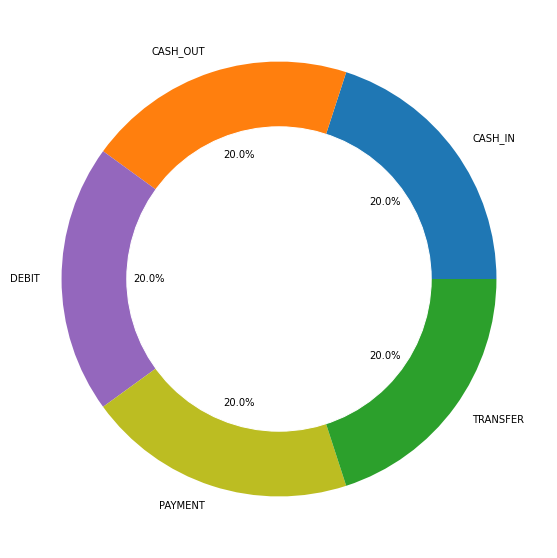

In [16]:
# representation of classes % wise
per_class = train_df["type"].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [17]:
# randomly sampling from each class
classes=train_df.groupby("type",group_keys=False).apply(lambda df : df.sample(1))
classes

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6066749,514,0,15049.61,2067179,121405.0,136454.61,560631,1.344143e+06,1.329093e+06,0,0
1947067,177,1,228382.58,1459980,0.0,0.00,312603,4.243935e+05,6.527761e+05,0,0
4876997,348,2,24358.02,137763,10060.0,0.00,485216,3.278278e+08,3.278521e+08,0,0
4024951,299,3,11912.08,4373525,202869.0,190956.92,1467997,0.000000e+00,0.000000e+00,0,0
2114207,183,4,735211.19,4728494,403686.0,0.00,306959,1.698446e+05,9.050558e+05,0,0


In [76]:
#Normalizing data
X=train_df.drop('isFraud',axis=1)
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X)
df_final=pd.DataFrame(x_scaled,columns=X.columns)
df_final.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,0.350543,0.0,0.001533,0.039487,0.134566,0.162427,0.193627,0.004868,0.004552,0.0
1,0.182065,0.0,0.001022,0.254576,0.035359,0.043904,0.166783,0.007701,0.010574,0.0
2,0.013587,0.0,0.000735,0.243600,0.128866,0.154096,0.208939,0.001360,0.001209,0.0
3,0.471467,0.0,0.003323,0.121757,0.000000,0.006577,0.184384,0.022598,0.021912,0.0
4,0.536685,0.0,0.002074,0.483069,0.227521,0.273602,0.167949,0.013354,0.012926,0.0


In [77]:
Y=train_df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(df_final, Y, test_size=0.40 , random_state=1)

#X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.4 , random_state=1)
#X_train, X_cv, y_train, y_cv = train_test_split(X, Y, test_size=0.25 , random_state=1)

In [78]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(40000, 10)
(60000,)
(40000,)


In [79]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression()

In [80]:
y_pred = LogReg.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [81]:
mse = mean_squared_error(y_test,y_pred)
acc=LogReg.score(X_test,y_test)

In [82]:
print("Mean Squared Error",mse)
print("Accuracy",acc)
#print("Validation Accuracy",v_acc)

Mean Squared Error 0.001825
Accuracy 0.998175


In [99]:
#K-Fold
cv = KFold(n_splits=10, shuffle=True, random_state=0)
model = LogReg
scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
print(scores)

[0.9989 0.9991 0.9988 0.9984 0.9984 0.9984 0.9992 0.9989 0.9991 0.9991]


In [85]:
print(mean(scores))
print(std(scores))

0.9988300000000001
0.00030347981810988414


In [106]:
#StratifiedKFold
skf = StratifiedKFold(n_splits=10)
model = LogisticRegression(solver='newton-cg')
x = train_df
y = train_df.isFraud
s=[]

def training(train, test, fold_no):
  x_trains = train.drop(['isFraud'],axis=1)
  y_trains = train.isFraud
  x_tests = test.drop(['isFraud'],axis=1)
  y_tests = test.isFraud
  model.fit(x_trains, y_trains)
  score1 = model.score(x_tests,y_tests)
  print('For Fold {} the accuracy is {}'.format(str(fold_no),score1))
  s.append(score1)

fold_no = 1
for train_index,test_index in skf.split(x, y):
  train = df.iloc[train_index,:]
  test = df.iloc[test_index,:]
  training(train, test, fold_no)
  fold_no += 1

For Fold 1 the accuracy is 0.9942
For Fold 2 the accuracy is 0.9989
For Fold 3 the accuracy is 0.9997
For Fold 4 the accuracy is 0.9988
For Fold 5 the accuracy is 0.9996
For Fold 6 the accuracy is 0.9997
For Fold 7 the accuracy is 0.9997
For Fold 8 the accuracy is 0.9995
For Fold 9 the accuracy is 0.9999
For Fold 10 the accuracy is 0.9996


In [108]:
print(mean(s))

0.99896


In [109]:
#StratifiedKFold showed aslightly higher mean accuracy/score than the normal K-Fold

In [110]:
#The Regularization technique used here is L2 Reg(RIDGE)
p_val=[]
p_train=[]
min=[]
C_param_range = [0.001,0.01,0.1,1,5,10,50,100]
for i in C_param_range:
    LogReg=LogisticRegression(C=i)
    LogReg.fit(X_train,y_train)
    pred_val=LogReg.predict(X_test)
    accuracy_val=accuracy_score(y_test,pred_val)
    err_val=1-accuracy_val
    p_val.append(1-accuracy_val)
    
    pred_train=LogReg.predict(X_train)
    accuracy_train=accuracy_score(y_train,pred_train)
    p_train.append(1-accuracy_train)

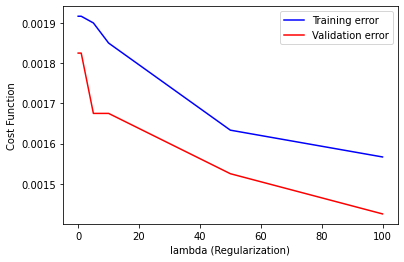

In [113]:
fig, ax = plt.subplots()
ax.plot(C_param_range, p_train, '-b', label='Training error')
ax.plot(C_param_range, p_val, '-r', label='Validation error')
plt.xlabel("lambda (Regularization)")
plt.ylabel("Cost Function")
leg = ax.legend();

In [114]:
#As the graph shows, the Validation error converges to a lower minumum (lower cost function), which interprets a good result